In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import PIL
import json
import dataclasses
import numpy as np

from typing import List
from dataset import TrainDataset
from dataclasses import dataclass

import torch
import torch.nn.functional as F
from accelerate import Accelerator
from diffusers.loaders import AttnProcsLayers, LoraLoaderMixin
from diffusers.models.attention_processor import LoRAAttnProcessor
from diffusers.schedulers import DDPMScheduler, LMSDiscreteScheduler
from diffusers.pipelines import StableDiffusionPipeline, DiffusionPipeline

from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
from datasets import load_dataset
from pathlib import Path

In [3]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [4]:
MAIN_name = 'hamburger'
DATA_name = 'hamburger'
LR = 2e-4

@dataclass
class TrainingConfig:
    # Task specific parameters
    instance_prompt: str = "photo of a [V] " + MAIN_name
    class_prompt: str = "photo of a " + MAIN_name
    evaluate_prompt = ["photo of a " + MAIN_name]*4 + ["photo of a [V] "+ MAIN_name]*4
    data_path: str = "./data/" + DATA_name
    identifier: str = "o$%c7"

    # Basic Training Parameters
    num_epochs: int = 3
    train_batch_size: int = 1
    learning_rate: float = LR
    image_size: int = 512 # the generated image resolution
    gradient_accumulation_steps: int = 1

    # Hyperparmeter for diffusion models
    num_train_timesteps: int = 9000
    train_guidance_scale: float = 0 # guidance scale at training
    sample_guidance_scale: float = 6.5 # guidance scale at inference

    # Practical Training Settings
    mixed_precision: str = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    save_image_epochs: int = 1
    save_model_epochs: int = 1
    output_dir: str = 'logs/' + DATA_name
    overwrite_output_dir: bool = True  # overwrite the old model when re-running the notebook
    seed: int = 42

    def __post_init__(self):
        self.instance_prompt = self.instance_prompt.replace("[V]", self.identifier)
        self.evaluate_prompt = [s.replace("[V]", self.identifier) for s in self.evaluate_prompt]
        
def pred(model, noisy_latent, time_steps, prompt, guidance_scale):
    batch_size = noisy_latent.shape[0]
    text_input = model.tokenizer(
        prompt,
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    
    with torch.no_grad():
        text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0]
    
    latent_model_input = noisy_latent
    time_steps = time_steps
    noise_pred = model.unet(
        latent_model_input, 
        time_steps, 
        encoder_hidden_states=text_embeddings
    )["sample"]

    return noise_pred
   
def train_loop(config: TrainingConfig, model: StableDiffusionPipeline, noise_scheduler, lora_layers, optimizer, train_dataloader):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 

    )
    accelerator.register_for_checkpointing(lora_layers)
    
    if accelerator.is_main_process:
        accelerator.init_trackers("train_example")

    lora_layers, model, optimizer, train_dataloader = accelerator.prepare(
        lora_layers, model, optimizer, train_dataloader 
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        # print(epoch, config.num_epochs, len(train_dataloader), global_step)

        for step, batch in enumerate(train_dataloader):
            instance_imgs, instance_prompt, class_imgs, class_prompt = batch
            imgs = torch.cat((instance_imgs, class_imgs), dim=0)
            prompt = instance_prompt + class_prompt

            # Sample noise to add to the images
            bs = imgs.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=accelerator.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            with torch.no_grad():
                latents = model.vae.encode(imgs).latent_dist.sample() * model.vae.config.scaling_factor
                noise = torch.randn(latents.shape, device=accelerator.device)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = pred(model, noisy_latents, timesteps, prompt, guidance_scale=config.train_guidance_scale)
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                
                if accelerator.sync_gradients:
                    params_to_clip = lora_layers.parameters()
                    accelerator.clip_grad_norm_(params_to_clip, 1.0)
                    
                optimizer.step()
                optimizer.zero_grad()
            
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            if epoch % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, model)
                
            LoraLoaderMixin.save_lora_weights(
                save_directory=config.output_dir,
                unet_lora_layers=lora_layers,
            )
                
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config: TrainingConfig, epoch, pipeline: StableDiffusionPipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    with torch.no_grad():
        with torch.autocast("cuda"):
            images = pipeline(
                config.evaluate_prompt, 
                num_inference_steps=50, 
                width=config.image_size, 
                height=config.image_size, 
                guidance_scale=config.sample_guidance_scale
            ).images
            
    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.jpg")

def get_dataloader(config: TrainingConfig):
    dataset = TrainDataset(config.data_path, config.instance_prompt, config.class_prompt, config.image_size)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True, drop_last=True, pin_memory=True)
    return dataloader

In [5]:
config = TrainingConfig()
output_dir = Path(config.output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / "config.json", "w") as f:
    json.dump(dataclasses.asdict(config) , f)

model_id = "../../stablediffusion/stable-diffusion-2-1-base"
device = "cuda"

model = StableDiffusionPipeline.from_pretrained(model_id,).to(device)

# We only train the additional adapter LoRA layers
model.vae.requires_grad_(False)
model.text_encoder.requires_grad_(False)
model.unet.requires_grad_(False)

# Set correct lora layers
lora_attn_procs = {}
for name in model.unet.attn_processors.keys():
    cross_attention_dim = None if name.endswith("attn1.processor") else model.unet.config.cross_attention_dim
    if name.startswith("mid_block"):
        hidden_size = model.unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(model.unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = model.unet.config.block_out_channels[block_id]

    lora_attn_procs[name] = LoRAAttnProcessor(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim)

model.unet.set_attn_processor(lora_attn_procs)
lora_layers = AttnProcsLayers(model.unet.attn_processors).to(device)

all_param = list(lora_layers.state_dict().items())
for param in lora_layers.parameters():
    param.requires_grad_(True)

# lora_layers._load_state_dict_pre_hooks.clear()
# lora_layers._state_dict_hooks.clear()

train_dataloader = get_dataloader(config)
optimizer = torch.optim.AdamW(lora_layers.parameters(), lr=config.learning_rate)
noise_scheduler = noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

train_loop(config, model, noise_scheduler, lora_layers, optimizer, train_dataloader)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

instance 6
class 200


/home/ud202381473/.conda/envs/dreamfusion/lib/python3.8/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

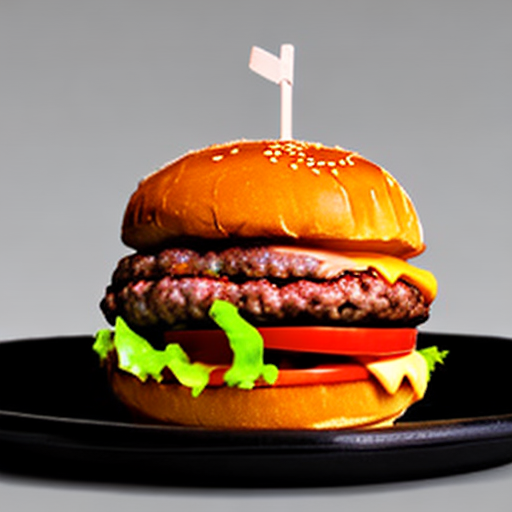

In [6]:
with torch.no_grad():
    with torch.autocast("cuda"):
        images = model(
            # 'a o$%c7 schoolbus toy',
            # 'a schoolbus toy',
            "photo of a o$%c7 "+MAIN_name,
            num_inference_steps=50,
            width=512, 
            height=512, 
            guidance_scale=6.5
        ).images
images[0]

In [7]:
@dataclass
class TrainingConfig2:
    # Task specific parameters
    instance_prompt: str = "photo of a [S] [V] "+MAIN_name
    class_prompt: str = "photo of a [V] "+MAIN_name
    evaluate_prompt = ["photo of a [V] "+MAIN_name]*4 + ["photo of a [S] [V] "+MAIN_name]*2 + ["concept art of a [S] [V] "+MAIN_name+" by carne griffiths"]*2
    data_path: str = "./data/"+DATA_name+"-2"
    identifier: str = "o$%c7"
    identifier2: str = "ItU@T"

    # Basic Training Parameters
    num_epochs: int = 1
    train_batch_size: int = 1
    learning_rate: float = LR
    image_size: int = 512 # the generated image resolution
    gradient_accumulation_steps: int = 1

    # Hyperparmeter for diffusion models
    num_train_timesteps: int = 9000
    train_guidance_scale: float = 0 # guidance scale at training
    sample_guidance_scale: float = 6.5 # guidance scale at inference

    # Practical Training Settings
    mixed_precision: str = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    save_image_epochs: int = 1
    save_model_epochs: int = 1
    output_dir: str = 'logs/'+DATA_name+"-2"
    overwrite_output_dir: bool = True  # overwrite the old model when re-running the notebook
    seed: int = 42

    def __post_init__(self):
        self.instance_prompt = self.instance_prompt.replace("[V]", self.identifier)
        self.class_prompt = self.class_prompt.replace("[V]", self.identifier)
        self.evaluate_prompt = [s.replace("[V]", self.identifier) for s in self.evaluate_prompt]
        
        self.instance_prompt = self.instance_prompt.replace("[S]", self.identifier2)
        self.class_prompt = self.class_prompt.replace("[S]", self.identifier2)
        self.evaluate_prompt = [s.replace("[S]", self.identifier2) for s in self.evaluate_prompt]

In [8]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [9]:
# config2.instance_prompt

In [10]:
config2 = TrainingConfig2()
output_dir = Path(config2.output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

model_id = "../../stablediffusion/stable-diffusion-2-1-base"
device = "cuda"

model = StableDiffusionPipeline.from_pretrained(model_id,).to(device)

# We only train the additional adapter LoRA layers
model.vae.requires_grad_(False)
model.text_encoder.requires_grad_(False)
model.unet.requires_grad_(False)

model.load_lora_weights("logs/"+DATA_name)
lora_layers = AttnProcsLayers(model.unet.attn_processors)

train_dataloader = get_dataloader(config2)
optimizer = torch.optim.AdamW(lora_layers.parameters(), lr=config2.learning_rate)
noise_scheduler = noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

train_loop(config2, model, noise_scheduler, lora_layers, optimizer, train_dataloader)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

instance 1
class 5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

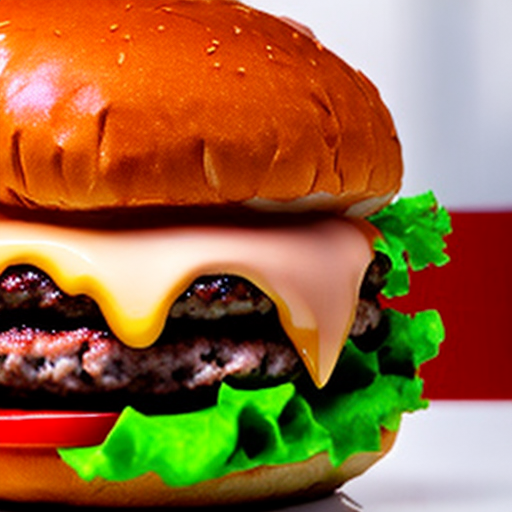

In [21]:
with torch.no_grad():
    with torch.autocast("cuda"):
        images = model(
            'photo of a ItU@T o$%c7 '+MAIN_name,
            # 'photo of a o$%c7 '+MAIN_name,
            # 'a '+MAIN_name,
            num_inference_steps=50,
            width=512, 
            height=512, 
            guidance_scale=6.5
        ).images
images[0]

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import CLIPTextModel, CLIPTokenizer, logging
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    DDIMScheduler,
    StableDiffusionPipeline,
)

class StableDiffusion(nn.Module):
    def __init__(
        self,
        device,
        fp16=True,
        vram_O=False,
        sd_version="2.1",
        hf_key=None,
        t_range=[0.02, 0.98],
    ):
        super().__init__()

        self.device = device
        self.dtype = torch.float32
        model_key = '../../stablediffusion/stable-diffusion-2-1-base'
        # Create model
        pipe = StableDiffusionPipeline.from_pretrained(
            model_key, torch_dtype=self.dtype
        ).to(device)
        
        pipe.load_lora_weights('logs/'+DATA_name+"-2")

        self.vae = pipe.vae
        self.tokenizer = pipe.tokenizer
        self.text_encoder = pipe.text_encoder
        self.unet = pipe.unet

        self.scheduler = DDIMScheduler.from_pretrained(
            model_key, subfolder="scheduler", torch_dtype=self.dtype
        )
        
        for param in self.vae.parameters():
            param.requires_grad = False 
        for param in self.unet.parameters():
            param.requires_grad = False 
        for param in self.text_encoder.parameters():
            param.requires_grad = False 

        del pipe

        self.num_train_timesteps = self.scheduler.config.num_train_timesteps
        self.min_step = int(self.num_train_timesteps * t_range[0])
        self.max_step = int(self.num_train_timesteps * t_range[1])
        self.alphas = self.scheduler.alphas_cumprod.to(self.device)  # for convenience

        self.embeddings = None

    @torch.no_grad()
    def get_text_embeds(self, prompts, negative_prompts):
        pos_embeds = self.encode_text(prompts)  # [1, 77, 768]
        neg_embeds = self.encode_text(negative_prompts)
        self.embeddings = torch.cat([neg_embeds, pos_embeds], dim=0)  # [2, 77, 768]
    
    def encode_text(self, prompt):
        # prompt: [str]
        inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        )
        embeddings = self.text_encoder(inputs.input_ids.to(self.device))[0]
        return embeddings

    @torch.no_grad()
    def refine(self, pred_rgb, guidance_scale=100, steps=50, strength=0.8,):
        batch_size = pred_rgb.shape[0]
        pred_rgb_512 = F.interpolate(pred_rgb, (512, 512), mode='bilinear', align_corners=False)
        latents = self.encode_imgs(pred_rgb_512.to(self.dtype))
        # latents = torch.randn((1, 4, 64, 64), device=self.device, dtype=self.dtype)

        self.scheduler.set_timesteps(steps)
        init_step = int(steps * strength)
        latents = self.scheduler.add_noise(latents, torch.randn_like(latents), self.scheduler.timesteps[init_step])

        for i, t in enumerate(self.scheduler.timesteps[init_step:]):
    
            latent_model_input = torch.cat([latents] * 2)

            noise_pred = self.unet(
                latent_model_input, t, encoder_hidden_states=self.embeddings,
            ).sample

            noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
            
            latents = self.scheduler.step(noise_pred, t, latents).prev_sample

        imgs = self.decode_latents(latents) # [1, 3, 512, 512]
        return imgs
    
    def decode_latents(self, latents):
        latents = 1 / self.vae.config.scaling_factor * latents

        imgs = self.vae.decode(latents).sample
        imgs = (imgs / 2 + 0.5).clamp(0, 1)

        return imgs

    def encode_imgs(self, imgs):
        # imgs: [B, 3, H, W]

        imgs = 2 * imgs - 1

        posterior = self.vae.encode(imgs).latent_dist
        latents = posterior.sample() * self.vae.config.scaling_factor

        return latents

In [22]:
device = torch.device('cuda')
sd = StableDiffusion(device)
sd.get_text_embeds('photo of a ItU@T o$%c7 '+MAIN_name, '')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

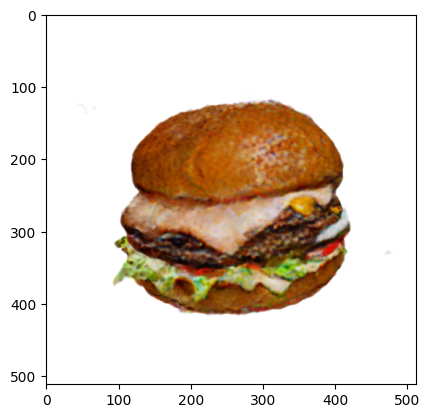

In [25]:
rgb = Image.open('usd_rendering/20.png')
rgb = rgb.resize((512, 512), resample=PIL.Image.BILINEAR).convert("RGB")
rgb = torch.Tensor(np.array(rgb) / 255.)
plt.imshow(rgb)

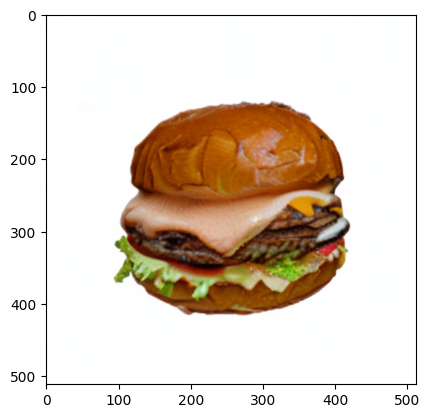

In [32]:
input_rgb = rgb.permute(2, 0, 1)[None, ...].to(device)
image = sd.refine(input_rgb, guidance_scale=6.5, strength=0.8)
plt.imshow(image.permute(0, 2, 3, 1)[0].cpu())